* [`torchvision`](https://pytorch.org/vision/stable/index.html) - base domain library for pytorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for cv
* `torchvision.models` - get pretrained models 
* `torchvision.transforms` - functions for manipulating vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - base dataset class for pytorch
* `torch.utils.data.DataLoader` - creates a python iterable over a dataset

In [ ]:
import torch
from torch import nn 

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
#dataset used : FashionMNIST
#setup training data

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [ ]:
train_data[0][0].shape


torch.Size([1, 28, 28])

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

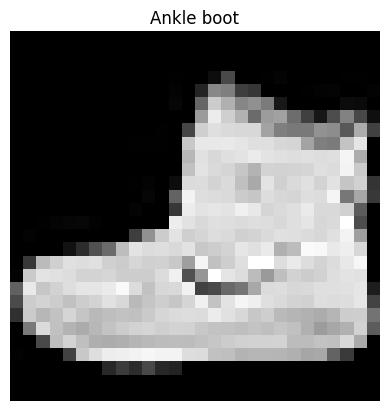

In [ ]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)

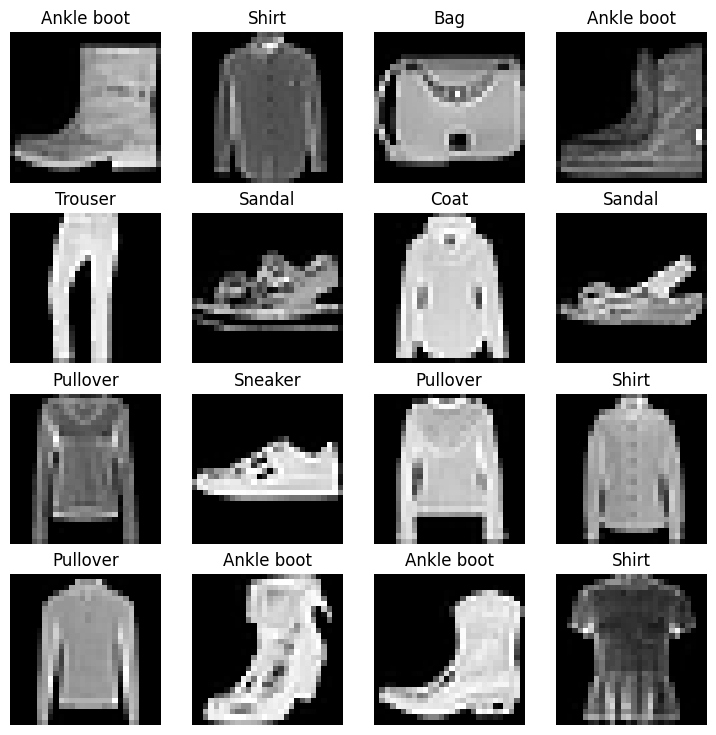

In [ ]:
#plot more
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
classes = train_data.classes

rows, cols = 4, 4

for i in range(1,rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False)



In [ ]:
# prepare dataloader, DataLoader turns data into iterable -> turn data into batches
# this is more computationally efficient, can't store 60k images in one go. more chances for nn to update gradients per epoch
# https://www.youtube.com/watch?v=l4lSUAcvHFs&ab_channel=ArtificialIntelligence-AllinOne

from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # no need, faster

In [ ]:
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 1875 batches of 32
Test dataloader: 313 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image shape: torch.Size([1, 28, 28])


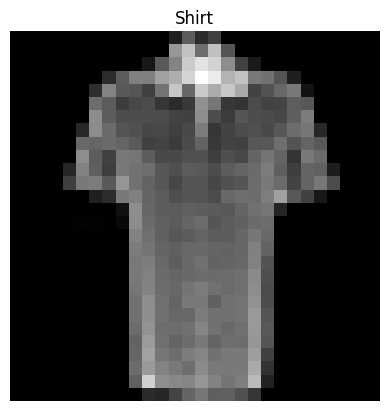

In [ ]:
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis(False)
plt.title(train_data.classes[label])
print(f"Image shape: {img.shape}")


In [ ]:
# model 0 - baseline

# create a flatten layer
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(x.shape)

#flatten 
out = flatten_model(x)
print(out.shape)
print(out.squeeze().shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([784])


In [ ]:
from torch import nn

class FashionMNISTv0(nn.Module):
  def __init__(self,
               input_shape: int, 
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
#setup model with input params

model_0 = FashionMNISTv0(input_shape=28*28, hidden_units=10, output_shape=len(classes))
model_0.to("cpu")


FashionMNISTv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand(size=[1,1,28,28]).to("cpu")
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
def accuracy_fn(y_true, y_pred):
  corr = torch.eq(y_true, y_pred).sum().item()
  return (corr / len(y_pred))*100

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# optimizer will update model's params once per batch rather than once per epoch...
# tqdm for progress bar

In [ ]:
# training loop - training on batches of data
# loop through epochs
# loop through training batches, perform training steps, calculate the train loss per batch
# loop through testing batches, perform testing steps, calculate the test loss per batch

In [ ]:
%%time
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}")
  # training
  train_loss = 0
  # loop to loop through batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # fwd pass
    y_pred = model_0(X)

    #calc loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    opt.zero_grad()

    loss.backward()

    opt.step()

    if batch % 400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
  
  #divide total train loss by len of train dataloader
  train_loss /= len(train_dataloader)

  # testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    #calculate test loss avg per batch
    test_loss /= len(test_dataloader)

    #calculate test acc avg per batch
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch:1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch:2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
CPU times: user 34.4 s, sys: 122 ms, total: 34.5 s
Wall time: 34.6 s


In [ ]:
# make predictions and get results

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """ Returns a dict containing the results of model predicting on data loader. """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn,
                             device="cpu")
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTv0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )
  
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28*28 image goes in
                              hidden_units=10,
                              output_shape=len(classes)).to(device) # send to the GPU if it's available
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device 
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)
    
    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
  
  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0
  
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels 

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
%%time

torch.manual_seed(42)

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
----------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
----------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

CPU times: user 36.2 s, sys: 339 ms, total: 36.6 s
Wall time: 36.7 s


In [ ]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x) 
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(classes)).to(device)

## Stepping through nn.Conv2d()

In [ ]:
torch.manual_seed(42)

# Create a batch of images - pytorch defaults to color channels first 
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0] 

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer 
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

## Stepping through nn.MaxPool2d()

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)
# Create a random tesnor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


## Setup a loss function and optimizer for model_2

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
%%time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59583 | Train acc: 78.34%
Test loss: 0.40492 | Test acc: 85.34%

Epoch: 1
-------
Train loss: 0.36193 | Train acc: 87.01%
Test loss: 0.36312 | Test acc: 86.52%

Epoch: 2
-------
Train loss: 0.32506 | Train acc: 88.25%
Test loss: 0.32108 | Test acc: 88.31%

CPU times: user 44.7 s, sys: 378 ms, total: 45.1 s
Wall time: 52 s


In [ ]:
# Get model_2 results
model_2_results = eval_model(
     model=model_2,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3210791349411011,
 'model_acc': 88.30870607028754}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTv0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.321079,88.308706


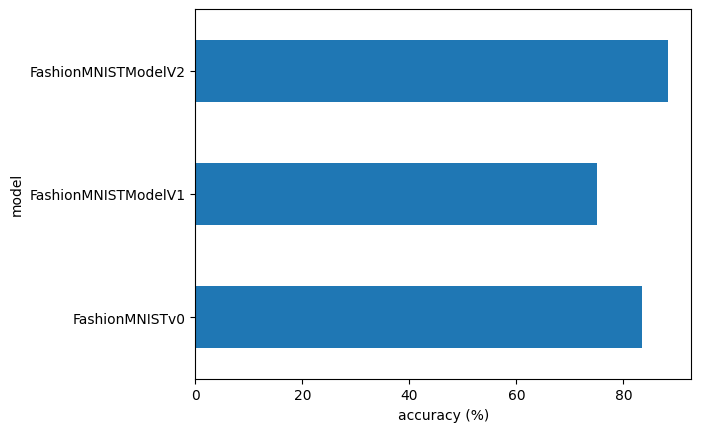

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)
test_samples = [] 
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

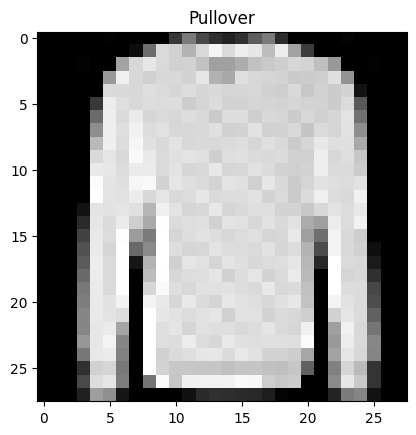

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(classes[test_labels[0]])

In [ ]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

pred_probs

tensor([[1.1336e-02, 1.6387e-04, 9.5611e-01, 7.1479e-04, 3.0704e-03, 1.4733e-05,
         2.8480e-02, 2.4027e-06, 5.2195e-05, 5.2560e-05],
        [4.8549e-03, 1.0465e-03, 5.0373e-01, 1.9987e-03, 4.6908e-01, 9.3113e-05,
         1.8129e-02, 1.0670e-04, 9.0407e-04, 6.1093e-05],
        [9.0426e-01, 1.1099e-05, 1.8421e-03, 6.2826e-02, 1.7203e-04, 2.3538e-06,
         3.0741e-02, 2.0468e-06, 1.4827e-04, 2.5813e-07],
        [9.7742e-06, 5.7927e-06, 9.5049e-06, 4.3651e-05, 1.4969e-05, 1.5248e-03,
         2.3345e-06, 9.9649e-01, 3.6700e-04, 1.5344e-03],
        [8.9689e-04, 1.6686e-06, 9.9833e-01, 3.1843e-05, 3.0377e-04, 1.7630e-06,
         4.3345e-04, 3.9699e-08, 5.7093e-07, 3.3980e-07],
        [5.2359e-03, 4.9352e-05, 2.9072e-04, 9.8172e-01, 3.4231e-03, 3.4916e-05,
         1.3498e-03, 3.7178e-05, 7.8573e-03, 1.5342e-06],
        [8.7233e-03, 7.2283e-05, 6.5149e-01, 2.4007e-04, 1.4759e-02, 1.7932e-05,
         3.2405e-01, 2.1626e-06, 5.5254e-04, 9.2174e-05],
        [9.5693e-01, 1.5763

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 2, 0, 7, 2, 3, 2, 0, 3])

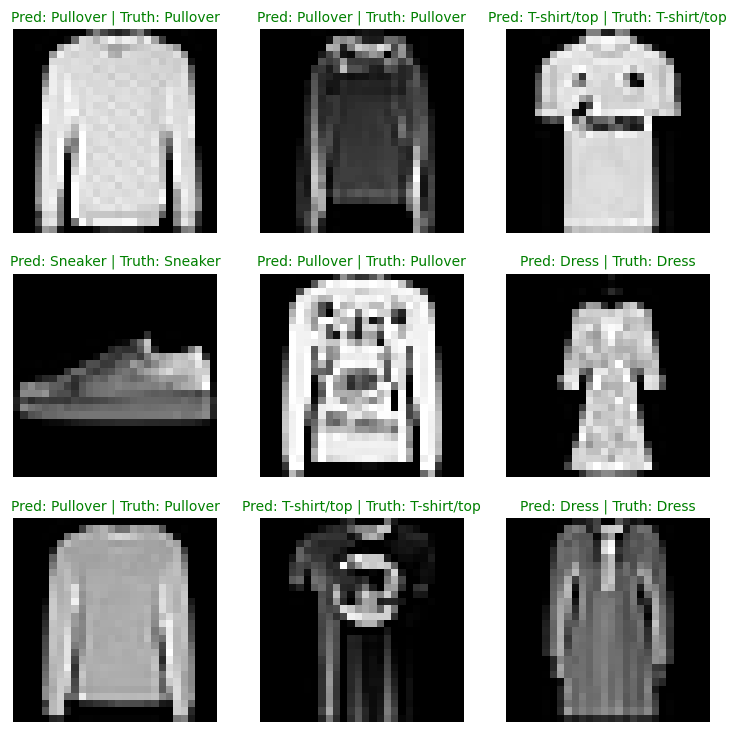

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form) 
  truth_label = classes[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") 
  
  plt.axis(False);

## Making a confusion matrix for further prediction evaluation

In [ ]:
from tqdm.auto import tqdm 


# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend 
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mlxtend version: 0.22.0


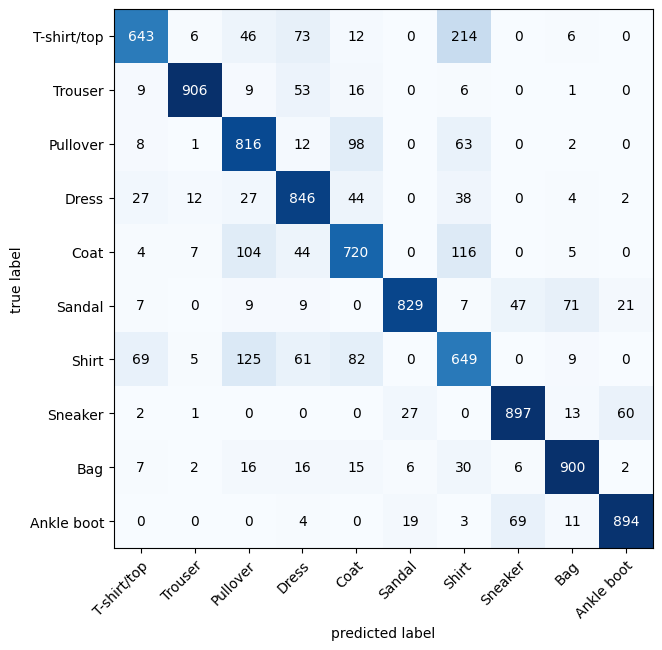

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
)

## Save and load best performing model

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(classes))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3210791349411011,
 'model_acc': 88.30870607028754}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3210791349411011,
 'model_acc': 88.30870607028754}